In [1]:
# default_exp fitting

# Data Likelihood Under Model
To fit a model to some dataset, we select a cost function that scales against the likelihood that the model with a specified parameter configuration could have generated the specified dataset. We'll demonstrate the process of designing a log-likelihood cost function and applying it to fit model parameters here.

In [1]:
# export

import numpy as np
from numba import njit, prange
from numba.typed import Dict
from numba.core import types

@njit(nogil=True, parallel=True)
def murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters):

    result = 0.0
    for i in prange(len(item_counts)):
    #for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        likelihood = np.ones((len(trials), item_count))

        model = model_class(item_count, item_count, parameters)
        model.experience(model.items)

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recall of indexed item
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities()[recall]
                # if likelihood[trial_index, recall_index] <= 0:
                #      print(trial_index, recall_index, recall, trial, model.outcome_probabilities())
                assert(likelihood[trial_index, recall_index] > 0)

                if recall == 0 or recall_index+1 == item_count:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)

        result -= np.sum(np.log(likelihood))

    return result

def murdock_objective_function(data_to_fit, item_counts, model_class, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for search over specified free/fixed parameters.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters)

    return objective_function

In [2]:
# export

import numpy as np
from numba import njit, prange
from compmemlearn.models import Classic_CMR
from numba.typed import Dict
from numba.core import types

@njit(fastmath=True, nogil=True, parallel=True)
def lohnas_data_likelihood(trials, presentations, model_class, parameters):

    list_length = len(presentations[0])
    likelihood = np.ones((len(trials), list_length))

    for trial_index in prange(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        trial = trials[trial_index]
        model = model_class(item_count, list_length, parameters)
        model.experience(model.items[presentations[trial_index]])

        model.force_recall()
        for recall_index in range(min(len(trial) + 1, item_count)):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            likelihood[trial_index, recall_index] = \
                model.outcome_probabilities()[recall]
            if likelihood[trial_index, recall_index] <= 0:
                print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())
            assert(likelihood[trial_index, recall_index] > 0)

            if recall == 0 or recall_index+1 == item_count:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def lohnas_objective_function(data_to_fit, presentations, model_class, fixed_parameters, free_parameters):

    """
    Generates and returns an objective function for input to support search 
    through parameter space for model fit using an optimization function.

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of likelihood using the model 
    class, all parameters, and provided data.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value

    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return lohnas_data_likelihood(data_to_fit, presentations, model_class, parameters)

    return objective_function

In [3]:
# export

from numba.typed import List
from compmemlearn.datasets import events_metadata

def generate_objective_function(
    trials, presentations, list_lengths, model_class, fixed_parameters, free_parameters):

    list_lengths = [list_lengths[i] for i in range(len(list_lengths)) if len(trials[i]) > 0]
    trials = [t for t in trials if len(t) > 0]
    presentations = [p for p in presentations if len(p) > 0]

    # generate function based on whether list contains item repetitions or not
    if len(trials) == 1:
        if (presentations[0] == np.arange(list_lengths[0])).all():
            return murdock_objective_function(
                List(trials), List(list_lengths), model_class, fixed_parameters, free_parameters)
        else:
            return lohnas_objective_function(
                trials[0], presentations[0], model_class, fixed_parameters, free_parameters)
    elif len(trials) > 1:
        return murdock_objective_function(
            List(trials), List(list_lengths), model_class, fixed_parameters, free_parameters)
    else:
        raise ValueError("No trials provided.")

In [9]:
import pandas as pd
from compmemlearn.models import Instance_CMR as model_class

@njit(fastmath=True, nogil=True)
def init_model(item_count, presentation_count, parameters):
    return model_class(item_count, presentation_count, parameters)

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {
        "choice_sensitivity": 1,
        "feature_sensitivity": 1,
        "mfc_familiarity_scale": 0,
        "mcf_familiarity_scale": 0,
        "drift_familiarity_scale": 0,
    },
    {
        "context_sensitivity": 1,
        "feature_sensitivity": 1,
        "mfc_familiarity_scale": 0,
        "mcf_familiarity_scale": 0,
        "drift_familiarity_scale": 0,
    },
]

events = pd.read_csv('../../data/Murdock1962.csv')
trials, list_lengths, presentations = events_metadata(events)
print(generate_objective_function(trials, presentations, list_lengths, init_model, fixed_parameters[0], free_parameters[0]))

events = pd.read_csv('../../../compmemlearn/data/LohnasKahana2014.csv')
trials, list_lengths, presentations = events_metadata(events)
print(generate_objective_function(trials, presentations, list_lengths, init_model, fixed_parameters[0], free_parameters[0]))

events = pd.read_csv('../../data/HowardKahana2005.csv')
trials, list_lengths, presentations = events_metadata(events)
print(generate_objective_function(trials, presentations, list_lengths, init_model, fixed_parameters[0], free_parameters[0]))

<function murdock_objective_function.<locals>.objective_function at 0x000001E5BD509AF0>
<function lohnas_objective_function.<locals>.objective_function at 0x000001E5BD509B80>
<function lohnas_objective_function.<locals>.objective_function at 0x000001E5BD509550>


## Testing the Likelihood Functions
We'll make sure the likelihood functions still return expected values depending on pre-fitted parameters from our Murdock, 1962 and Lohnas & Kahana, 2014 dataset analyses.

In [5]:
from compmemlearn.models import Classic_CMR
from numba.typed import List, Dict
from compmemlearn.datasets import prepare_murdock1962_data, prepare_lohnas2014_data

### `murdock_data_likelihood`

In [6]:
murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 2)

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

fit_values = np.array([5.88304182e-01, 3.76144942e-02, 7.51294302e-01, 2.91680115e-01,
       1.00000000e+00, 1.39633721e-01, 5.62625588e+00, 4.28789782e+01,
       2.40537436e-02, 2.61824232e-01, 5.32941045e+00, 9.34036191e-01])

cmr_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(fit_values)):
    cmr_parameters[free_parameters[i]] = fit_values[i]
cmr_parameters['sampling_rule'] = 0
cmr_parameters['mfc_familiarity_scale'] = 0
cmr_parameters['mcf_familiarity_scale'] = 0
cmr_parameters['drift_familiarity_scale'] = 0

@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

print('murdock, 1962 == 80052.6888735279')
print(murdock_data_likelihood(
    (murd_trials0, murd_trials1, murd_trials2), 
    (murd_length0,murd_length1, murd_length2), 
    init_cmr, cmr_parameters))

%timeit murdock_data_likelihood(List([murd_trials0, murd_trials1, murd_trials2]), List([murd_length0,murd_length1, murd_length2]), init_cmr, cmr_parameters)

murdock, 1962 == 80052.6888735279
80052.6888735276
58.1 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### `lohnas_data_likelihood`

In [7]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

fit_values = np.array([8.52979921e-01, 9.68207643e-02, 9.64470531e-01, 3.73838044e-02,
       2.22044605e-16, 4.62850531e-01, 3.18792422e+00, 8.62357681e+01,
       2.13805131e-02, 1.06861707e-01, 1.18381379e+00, 9.83789369e-01])

for i in range(len(fit_values)):
    cmr_parameters[free_parameters[i]] = fit_values[i]

print('lohnas, 2014 == 17271.524963186363')
print(lohnas_data_likelihood(
    trials[list_types == 4], 
    presentations[list_types == 4], 
    init_cmr, cmr_parameters))

%timeit lohnas_data_likelihood(trials[list_types == 4], presentations[list_types == 4], init_cmr, cmr_parameters)

lohnas, 2014 == 17271.524963186363
17271.524963184707
38.7 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Fitting Pure Lists with `murdock_data_likelihood`

With the runtime of the cost function established, we'll now use it with scipy's `differential_evolution` function to find the best fit parameters for the model to the single subject we're examining.

### Loading and Optimizing Along Cost Function

In [8]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = murdock_objective_function(
    (murd_trials0, murd_trials1, murd_trials2), 
    (murd_length0,murd_length1, murd_length2), 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 110859
differential_evolution step 2: f(x)= 110859
differential_evolution step 3: f(x)= 100389
differential_evolution step 4: f(x)= 100389
differential_evolution step 5: f(x)= 93619.1
differential_evolution step 6: f(x)= 93619.1
differential_evolution step 7: f(x)= 93619.1
differential_evolution step 8: f(x)= 89937.3
differential_evolution step 9: f(x)= 85381.7
differential_evolution step 10: f(x)= 85381.7
differential_evolution step 11: f(x)= 85381.7
differential_evolution step 12: f(x)= 84879.4
differential_evolution step 13: f(x)= 84879.4
differential_evolution step 14: f(x)= 84879.4
differential_evolution step 15: f(x)= 83343.3
differential_evolution step 16: f(x)= 83343.3
differential_evolution step 17: f(x)= 83343.3
differential_evolution step 18: f(x)= 83010.9
differential_evolution step 19: f(x)= 83010.9
differential_evolution step 20: f(x)= 83010.9
differential_evolution step 21: f(x)= 82991
differential_evolution step 22: f(x)= 82991
diffe

We expect these results:

```
     fun: 80052.68887354505
     jac: array([  10.6170773 ,   17.17708073,   -2.77505022,   -2.50875019,
       -123.24599022,   17.89885574,   -2.93221094,    0.        ,
        118.13972376,   26.6605639 ,    7.70960473,    7.07950672])
 message: 'Optimization terminated successfully.'
    nfev: 7882
     nit: 36
 success: True
       x: array([5.88304182e-01, 3.76144942e-02, 7.51294302e-01, 2.91680115e-01,
       1.00000000e+00, 1.39633721e-01, 5.62625588e+00, 4.28789782e+01,
       2.40537436e-02, 2.61824232e-01, 5.32941045e+00, 9.34036191e-01])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

### Visualizing Fit
Next we'll visualize the fit of the model and its parameters to the data. We'll do this by simulating a dataset using the models and our parameters found above and plotting its simulated benchmark recall phenomena (serial position curve, lag-CRP, and probability of first recall) against the actual data. A new helper function called `apply_and_concatenate` helps streamline the process of setting up tables for comparison of an analysis outcome between simulated and real data.

In [9]:
# export
import pandas as pd

def apply_and_concatenate(function, dfs, contrast_name='contrast', labels='AB'):
    """
    Concatenates the results of a function applied to two dataframes and creates a new column identifying the contrast.
    """
    return pd.concat([function(df) for df in dfs], keys=labels, names=[contrast_name]).reset_index()
    

Now let's create some simulated data with our model and fitted parameters.

In [16]:
from compmemlearn.datasets import simulate_df
from psifr import fr
import seaborn as sns
import matplotlib.pyplot as plt

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(result.x)):
    fitted_parameters[free_parameters[i]] = result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
model1 = Classic_CMR(murd_length1, murd_length1, fitted_parameters)
model2 = Classic_CMR(murd_length2, murd_length2, fitted_parameters)

sim_df0 = simulate_df(model0, 1000)
sim_df1 = simulate_df(model1, 1000)
sim_df2 = simulate_df(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

Then extract summary statistics...

In [17]:
cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

cmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['PrototypeCMR', 'data'])
cmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr1 = cmr_pfr1.query('output <= 1')

cmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['PrototypeCMR', 'data'])
cmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr2 = cmr_pfr2.query('output <= 1')

And plot the result...

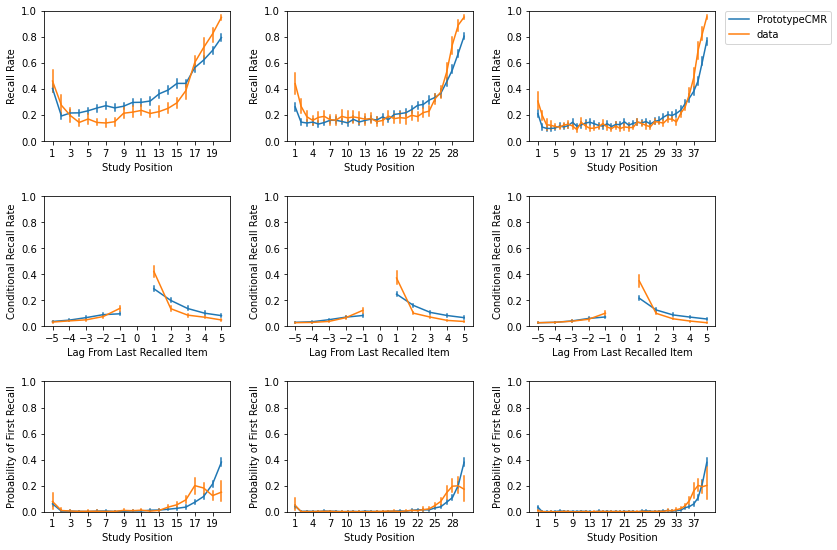

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=cmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=cmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

### Why aren't the fits better?
The model doesn't actually do a good job of capturing some of the quirks in the data -- namely the graded probability of first recall curve in that last plot. CMR predicts a much sharper curve than the actual data and its struggle to account for something different results in worse apparent fits to other benchmark recall phenomena visualized here too. At least, that's our best guess about what's behind the failure.

## Fitting Pure Lists with `lohnas_data_likelihood`
`lohnas_data_likelihood` is almost always slower than `murdock_data_likelihood` when it comes to fitting pure lists, but it's useful to confirm that the functions work similarly in the use cases under which they overlap.

In [ ]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

### Loading and Optimizing Along Cost Function

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types == 1], 
    presentations[list_types == 1], 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

In [ ]:
from compmemlearn.datasets import simulate_df

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[i]] = lohnas_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(40, 40, fitted_parameters)

sim_df0 = simulate_df(model0, 1000)
true_df0 = events.loc[events.condition==1]

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

### Let's compare this result with what we'd obtain if we fit using `murdock_data_likelihood`.

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = murdock_objective_function(
    (trials[list_types==1], ), 
    (40, ), 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

murdock_result = differential_evolution(cost_function, bounds, disp=True)
print(murdock_result)

In [ ]:
from compmemlearn.datasets import simulate_df

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(murdock_result.x)):
    fitted_parameters[free_parameters[i]] = murdock_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model0 = Classic_CMR(40, 40, fitted_parameters)

sim_df0 = simulate_df(model0, 1000)
true_df0 = events.loc[events.condition==1]

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

## Fitting Mixed Lists with `lohnas_data_likelihood`

In [ ]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate',
)

### Loading and Optimizing Along Cost Function

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types == 4], 
    presentations[list_types == 4], 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

In [ ]:
from compmemlearn.datasets import simulate_array_from_presentations
from compmemlearn.analyses import fast_rpl

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for j in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[j]] = lohnas_result.x[j]

fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

experiment_count = 1000
new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations[list_types==4], experiment_count)

In [ ]:
import numpy.matlib

result = fast_rpl(np.matlib.repmat(presentations[list_types==4], experiment_count, 1), new_sim_array)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

In [ ]:
import matplotlib.pyplot as plt

fit_sources = ['lohnas_4']
fit_rpls = [binned]

for i in range(len(fit_sources)):
    plt.plot(fit_rpls[i], label=fit_sources[i])

result = fast_rpl(presentations[list_types==4], trials[list_types==4])
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
plt.plot(binned, label='data')
lags = ['N/A', '0', '1-2', '3-5', '6-8']
plt.xticks(np.arange(len(lags)), lags)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### All Conditions

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types >= 1], 
    presentations[list_types >= 1], 
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

In [ ]:
from compmemlearn.datasets import simulate_array_from_presentations
from compmemlearn.analyses import fast_rpl

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for j in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[j]] = lohnas_result.x[j]

fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

experiment_count = 1000
new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations[list_types>=1], experiment_count)

In [ ]:
import numpy.matlib

result = fast_rpl(np.matlib.repmat(presentations[list_types>=1], experiment_count, 1), new_sim_array)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

In [ ]:
import matplotlib.pyplot as plt

fit_sources = ['fit_to_full_dataset']
fit_rpls = [binned]

for i in range(len(fit_sources)):
    plt.plot(fit_rpls[i], label=fit_sources[i])

result = fast_rpl(presentations[list_types>=1], trials[list_types>=1])
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
plt.plot(binned, label='data')
lags = ['N/A', '0', '1-2', '3-5', '6-8']
plt.xticks(np.arange(len(lags)), lags)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Differential Encoding

In [ ]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate',
    'mfc_familiarity_scale',
    'mcf_familiarity_scale',
    'drift_familiarity_scale',
)

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub)
)

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = lohnas_objective_function(
    trials[list_types == 4], 
    presentations[list_types == 4], 
    init_cmr,
    {'sampling_rule': 0}, 
    free_parameters)

lohnas_result = differential_evolution(cost_function, bounds, disp=True)
print(lohnas_result)

In [ ]:
from compmemlearn.datasets import simulate_array_from_presentations
from compmemlearn.analyses import fast_rpl

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for j in range(len(lohnas_result.x)):
    fitted_parameters[free_parameters[j]] = lohnas_result.x[j]

fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

experiment_count = 1000
new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations[list_types==4], experiment_count)

In [ ]:
import numpy.matlib

result = fast_rpl(np.matlib.repmat(presentations[list_types==4], experiment_count, 1), new_sim_array)
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
print(binned)

In [ ]:
import matplotlib.pyplot as plt

fit_sources = ['lohnas_4']
fit_rpls = [binned]

for i in range(len(fit_sources)):
    plt.plot(fit_rpls[i], label=fit_sources[i])

result = fast_rpl(presentations[list_types==4], trials[list_types==4])
binned = np.zeros(5)
binned[0] = result[0]
binned[1] = result[1]
binned[2] = (result[2] + result[3])/2
binned[3] = (result[4] + result[5] + result[6])/3
binned[4] = (result[7] + result[8] + result[9])/3
plt.plot(binned, label='data')
lags = ['N/A', '0', '1-2', '3-5', '6-8']
plt.xticks(np.arange(len(lags)), lags)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)